In [1]:
import neptune as neptune
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import tempfile

## Functions

In [20]:
def plot_loss_vs_lr(runs_table, ylim=None, title=None, figsize=(10, 6), ax=None, main_varible="job_config/common/dmodel", ax_labels_font=12, tick_font=12, title_font=12):
    """
    For each model width in the runs table, plots a line where the y-axis is the final loss value
    and the x-axis is the learning rate (lr). Uses different markers for finished vs running runs.

    Parameters:
    - runs_table (pd.DataFrame): The DataFrame returned by get_neptune_table(), containing run information.
    - ylim (tuple): Y-axis limits
    - title (str): Plot title
    - figsize (tuple): Figure size
    - ax (matplotlib axis): Axis to plot on
    - main_varible (str): Main variable column name
    - ax_labels_font (int): Font size for axis labels
    - tick_font (int): Font size for ticks
    - title_font (int): Font size for title

    Returns:
    - None
    """
    color_dict = {
        1: "#1f78b4",    # Blue
        2: "#33a02c",    # Green
        4: "#e31a1c",    # Red
        8: "#ff7f00",    # Orange
        16: "#6a3d9a",   # Purple
        32: "#a65628",     # Brown
        64: "#000000",   # Black
        
        # Main range - using ColorBrewer Set1 + extensions
        128: "#1f78b4",    # Blue
        256: "#33a02c",    # Green
        512: "#e31a1c",    # Red
        768: "#ff7f00",    # Orange
        1024: "#6a3d9a",   # Purple
        1536: "#a65628",     # Brown
        2048: "#000000",   # Black
    }

    # Ensure required columns are present in runs_table
    required_columns = ["sys/id", main_varible, "learning_rate", "job_config/trainer/n_steps", "step"]
    for col in required_columns:
        if col not in runs_table.columns:
            raise ValueError(
                f"Column '{col}' is missing from runs_table. Please include it in the 'columns' parameter when calling get_neptune_table()."
            )

    # Check for required columns to determine completion status
    required_status_columns = ["job_config/trainer/n_steps", "step"]
    has_completion_info = all(col in runs_table.columns for col in required_status_columns)
    
    if not has_completion_info:
        raise ValueError(
            f"Columns 'job_config/trainer/n_steps' and 'step' are required to determine run completion status."
        )
    
    # Get final loss values for each run
    final_loss_df = get_final_loss_values(runs_table, main_varible)

    # Remove entries with missing final loss
    final_loss_df = final_loss_df[final_loss_df["final_loss"].notnull()]
    
    # Add completion status based on comparing step with job_config/trainer/n_steps
    completion_map = {}
    for _, run_row in runs_table.iterrows():
        run_id = run_row["sys/id"]
        n_steps = run_row["job_config/trainer/n_steps"]
        current_step = run_row["step"]
        
        # Consider complete if current step equals or exceeds planned steps
        is_complete = current_step + 1 >= n_steps
        completion_map[run_id] = "complete" if is_complete else "running"
    
    final_loss_df["status"] = final_loss_df["run_id"].map(completion_map)

    final_loss_df.to_csv('final_loss_df.csv')

    # Plotting
    if ax is None:
        plt.figure(figsize=figsize)
        plot_ax = plt
    else:
        plot_ax = ax

    model_widths = sorted(final_loss_df["grid_variable"].unique())
    
    for model_width in model_widths:
        df_subset = final_loss_df[final_loss_df["grid_variable"] == model_width]
        
        # Separate finished and running runs
        finished_runs = df_subset[df_subset["status"] == "complete"]
        running_runs = df_subset[df_subset["status"] != "complete"]
        
        color = color_dict.get(model_width, None)
        
        if main_varible == "job_config/common/dmodel":
            variable_label = "Model width:"
        elif main_varible == "job_config/common/expansion_rate":
            variable_label = "Number of experts:"
        elif main_varible == "job_config/common/granularity":
            variable_label = "Granularity:"
        elif main_varible == "job_config/model/encoder/block_fn/attention_fn/top_k":
            variable_label = "top-k:"
        elif main_varible == "job_config/common/kv_heads":
            variable_label = "KV heads:"
            
        else:
            variable_label = "Type:"

        if type(model_width) is str:
            label_value = model_width.split('/')[-1]
        else:
            label_value = model_width
            
        label = f"{variable_label} {label_value}"
        
        # Plot finished runs with 'o' marker
        if not finished_runs.empty:
            finished_sorted = finished_runs.sort_values("lr")
            means_finished = finished_sorted.groupby("lr")["final_loss"].mean()
            lrs_finished = means_finished.index.to_numpy()
            losses_finished = means_finished.values
            
            if ax is None:
                plt.plot(lrs_finished, losses_finished, marker="o", color=color, 
                        label=label, linestyle='-')
            else:
                ax.plot(lrs_finished, losses_finished, marker="o", color=color,
                       label=label, linestyle='-')
        
        # Plot running runs with square marker
        if not running_runs.empty:
            running_sorted = running_runs.sort_values("lr")
            means_running = running_sorted.groupby("lr")["final_loss"].mean()
            lrs_running = means_running.index.to_numpy()
            losses_running = means_running.values
            
            if ax is None:
                plt.plot(lrs_running, losses_running, marker="s", color=color,
                        label=label, linestyle='--', markersize=6)
            else:
                ax.plot(lrs_running, losses_running, marker="s", color=color,
                       label=label, linestyle='--', markersize=6)

    if ax is None:
        plt.legend()
        plt.tick_params(axis='both', labelsize=tick_font)
        plt.xlabel("Learning Rate (lr)", fontsize=ax_labels_font)
        plt.ylabel("Final Loss Value", fontsize=ax_labels_font)
        if title is None:
            title = "Final Loss vs Learning Rate for Different Model Widths"
        plt.title(title, fontsize=title_font)
        plt.grid(True)
        plt.xscale("log")
        if ylim is not None:
            plt.ylim(ylim)
        plt.show()
    else:
        ax.legend()
        ax.set_xlabel("Learning Rate (lr)", fontsize=ax_labels_font)
        ax.set_ylabel("Final Loss Value", fontsize=ax_labels_font)
        ax.tick_params(axis='both', labelsize=tick_font)
        ax.set_xscale("log", base=2)
        if title is None:
            title = "Final Loss vs Learning Rate"
        ax.set_title(title, fontsize=title_font)
        ax.grid(True)
        if ylim is not None:
            ax.set_ylim(ylim)


def get_final_loss_values(runs_table, main_variable="job_config/common/dmodel"):
    """
    Fetches the final loss value for each run in the runs table.

    Parameters:
    - runs_table (pd.DataFrame): The DataFrame containing run information.

    Returns:
    - pd.DataFrame: A DataFrame with columns ['run_id', 'dmodel', 'lr', 'final_loss']
    """
    final_losses = []
    for _, run_row in runs_table.iterrows():
        run_id = run_row["sys/id"]
        model_width = run_row[main_variable]
        lr = run_row["learning_rate"]
        loss = run_row["steps/eval/loss"]

        final_losses.append(
            {"run_id": run_id, "grid_variable": model_width, "lr": lr, "final_loss": loss}
        )

    return pd.DataFrame(final_losses)


def add_losses_to_ax(ax, losses, label='diff', smoothing=1, x_trim_head=None, x_trim_tail=None):
    if x_trim_head is not None:
        losses = losses[x_trim_head :]

    if x_trim_tail is not None:
        losses = losses[: x_trim_tail]

    # average over non-overlapping chunks of size `smoothing`
    n = len(losses) // smoothing
    losses_trim = losses[: n * smoothing]
    losses_smooth = losses_trim.reshape(n, smoothing).mean(axis=1)
    token_ids = np.arange(n) * smoothing + smoothing // 2
    if x_trim_head is not None:
        token_ids += x_trim_head
    ax.plot(token_ids, losses_smooth, label='diff')


def plot_loss_vs_tokenid(jsons, run_names, title='plot', smoothing=1, x_trim_head=None, x_trim_tail=None, plot_type="separate"):
    assert len(run_names) == len(jsons)

    fig, ax = plt.subplots()

    if plot_type == "separate":
        for name, data in zip(run_names, jsons):
            losses = np.asarray(data["loss_per_token"])
            add_losses_to_ax(
                ax=ax,
                losses=losses,
                label=name,
                smoothing=smoothing,
                x_trim_head=x_trim_head,
                x_trim_tail=x_trim_tail,
            )

    if plot_type == "diff":
        losses_0 = np.asarray(jsons[0]["loss_per_token"])
        losses_1 = np.asarray(jsons[1]["loss_per_token"])
        losses = losses_0 - losses_1
        add_losses_to_ax(
            ax=ax,
            losses=losses,
            label='diff',
            smoothing=smoothing,
            x_trim_head=x_trim_head,
            x_trim_tail=x_trim_tail,
        )

    ax.set_xlabel("Token ID")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_title(title)
    plt.tight_layout()

    return fig



## Neptune

In [3]:
def get_neptune_table(tags, project="pmtest/llm-random", negative_tags=None, columns=None, print_columns=False):
    """
    Fetches a Neptune runs table filtered by tags and returns it as a pandas DataFrame.

    Parameters:
    - tags (list): List of tags to filter the runs.
    - negative_tags (list, optional): List of tags to exclude from the runs.
    - columns (list, optional): Additional columns to include in the runs table.
    - print_columns (bool, optional): If True, prints all available columns.

    Returns:
    - pandas.DataFrame: The runs table with the specified filters and columns.
    """

    # Initialize the Neptune project
    project = neptune.init_project(
        project=project,
        mode="read-only",
        api_token=os.environ["NEPTUNE_API_TOKEN"],
    )

    # Fetch the runs table with the specified tags and columns
    runs_table = project.fetch_runs_table(tag=tags, columns=columns).to_pandas()

    # Ensure 'sys/tags' is a list for each run
    # print(f"runs_table: {runs_table}")
    runs_table["sys/tags"] = runs_table["sys/tags"].apply(
        lambda x: x.split(",") if isinstance(x, str) else x
    )

    # Exclude runs containing any of the negative tags
    if negative_tags:
        for neg_tag in negative_tags:
            runs_table = runs_table[
                ~runs_table["sys/tags"].apply(lambda x: neg_tag in x)
            ]

    print(f"Table downloaded\nShape: {runs_table.shape}")

    if print_columns:
        print("\n=== Available columns ===")
        for col in sorted(runs_table.columns):
            print(f"  {col}")
        print("========================\n")

    return runs_table

def get_long_ctx_jsons(df, path=None, project="pmtest/llm-random", get_vars: list=None):
    dict_list = []
    for id in df["sys/id"].tolist():

        run = neptune.init_run(
            project=project,
            mode="read-only",
            api_token=os.environ["NEPTUNE_API_TOKEN"],
            with_id=id,
        )

        # grab the File object
        f = run[path]

        with tempfile.NamedTemporaryFile(suffix=".json") as tmp:
            f.download(tmp.name)
            tmp.seek(0)
            data = json.load(tmp)

        if get_vars is not None:
            for var in get_vars:
                data[var] = run[var].fetch()
                # print(f"{var}: {run[var].fetch()}")

        dict_list.append(data)

    return dict_list

## Context Scaling

In [5]:
tags = ["context_scaling", "2copt", "qk_norm_rms"]
negative_tags = []

df = get_neptune_table(tags, negative_tags=negative_tags)
print(df.shape)


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/
Table downloaded
Shape: (12, 921)
(12, 921)


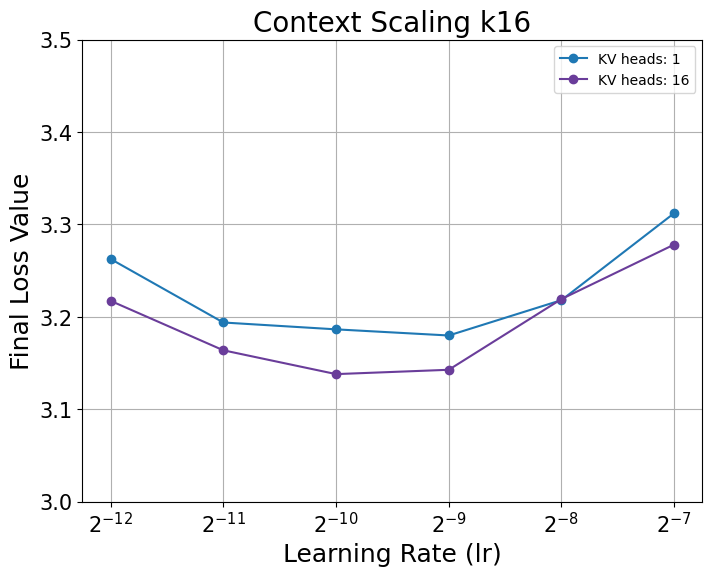

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
plot_loss_vs_lr(df, (3.0, 3.5), figsize=(6, 6), title="Context Scaling k16", ax=axes, main_varible='job_config/common/kv_heads', ax_labels_font=18, tick_font=15, title_font=20)

In [7]:
dict_list = get_long_ctx_jsons(df, path="eval_long_context/step_40000.json", get_vars=["job_config/common/kv_heads", "learning_rate"])
print(len(dict_list))

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41436


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41435


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41434


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41433


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41432


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41431


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41430


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41429


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41428


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41427


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41426


Fetching file...: 0 [00:00, ?/s]

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/pmtest/llm-random/e/LLMRANDOM-41425


Fetching file...: 0 [00:00, ?/s]

12


In [13]:
print(2 ** -9)
print(f"exp lr: {dict_list[1]['learning_rate']}")

0.001953125
exp lr: 0.001953125


In [14]:
filtered_list = []
names = []
for d in dict_list:
    if d["learning_rate"] == 0.001953125:
        filtered_list.append(d)
        names.append(f"kv_heads: {d["job_config/common/kv_heads"]}")

['kv_heads: 1', 'kv_heads: 16']


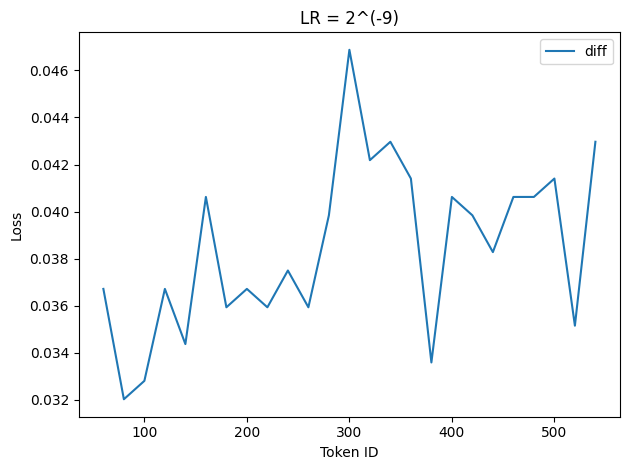

In [40]:
print(names)
fig = plot_loss_vs_tokenid(filtered_list, run_names=names, title='LR = 2^(-9)', smoothing=20, x_trim_head=50, x_trim_tail=500, plot_type='diff')